# Implementation of Deep Convolutional Generative Adversarial Networks (DCGAN) to generate art

### Libraries

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime
from tqdm import tqdm_notebook
from IPython.display import Image
import os

# For the handling of bad images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Parameters and definitions

In [2]:
datafolder = '../data/paintings' # path to the folder that contains the data

# Basic parameters
bsize = 128 # batch size
target_size = 64 # Target size for the resized images
code_size = 100 # Size of the input noise vector for the generator
epochs = 30 # Number of epochs to train
real_label = 0.9 # One sided label smoothing
fake_label = 0

# Optimizer parameters
betas = (0.5, 0.999)
lr = 0.0002

# Auxiliary definitions
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select gpu if available
figure_track = torch.randn(bsize, code_size, 1, 1, device=device) # constant noise to track the evolution of generator

# Device identifier for loading a model later on
marker = 'cpu'
if str(device) == 'cuda:0':
    marker = 'gpu'

# Date
y = str(datetime.today().year)[-2:]
m = str(datetime.today().month)
d = str(datetime.today().day)
h = str(datetime.today().hour)
model_date = y + '_' + m + '_' + d + '_' + h

# Create directory to save intermediate models
dir_name = '../models/{}'.format(model_date)

try:
    os.mkdir(dir_name)
    print("Directory " , dir_name ,  " created")
except FileExistsError:
    print("Directory " , dir_name ,  " already exists")

Directory  ../models/19_7_14_11  created


### Get, transform, shuffle and batch data

In [3]:
dataset = datasets.ImageFolder(datafolder, transform=transforms.Compose([transforms.Resize(target_size), 
                                                               transforms.CenterCrop(target_size), 
                                                               transforms.ToTensor(), 
                                                               transforms.Normalize((0.5,0.5,0.5),
                                                                                    (0.5,0.5,0.5))]))
    

dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize, shuffle=True)

### Visualize some training data

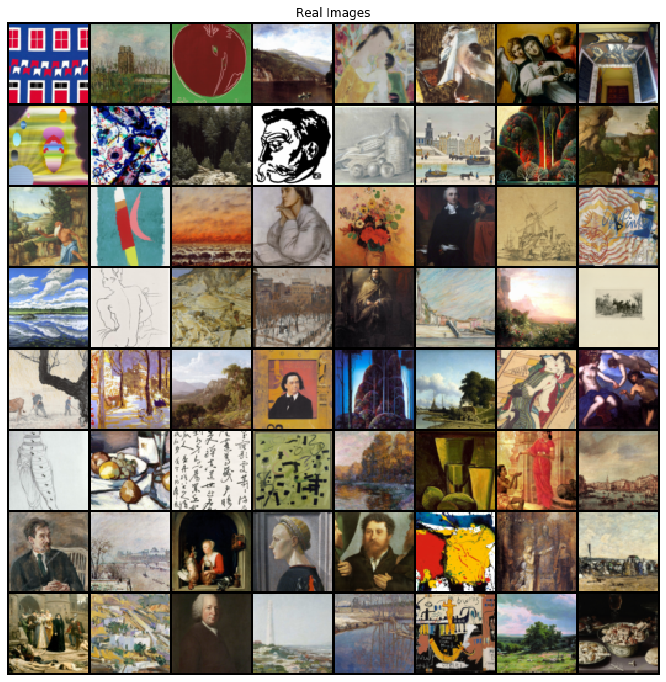

In [4]:
dataiter = iter(dataloader)
real_batch = dataiter.next()
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))

### Model definitions

##### To do
- Decide about `bias=False`
- What is wrong with `F.sigmoid()` and `F.tanh`?
- Get the dimensions clearly understood

##### Solved
> *As per the DCGAN paper:*
- Add BatchNorm2d
- Add LeakyReLU
- Add stride
- Decide about linear layers

- `super(Net, self).__init__()` is for backward compatibility only

#### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64*2)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.bn3 = nn.BatchNorm2d(64*8)
        
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.bn1(self.conv2(x)))
        x = self.lrelu(self.bn2(self.conv3(x)))
        x = self.lrelu(self.bn3(self.conv4(x)))
        x = self.conv5(x).sigmoid()
        return x

#### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # in, out, kernel, stride, padding
        self.convt1 = nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False) # 8x8x512
        self.convt2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False) # 16x16x256
        self.convt3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False) # 32x32x128
        self.convt4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False) # 64x64x64
        self.convt5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False) # 64x64x3
        
        self.bn1 = nn.BatchNorm2d(64*8)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.bn4 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.convt1(x)))
        x = F.relu(self.bn2(self.convt2(x)))
        x = F.relu(self.bn3(self.convt3(x)))
        x = F.relu(self.bn4(self.convt4(x)))
        x = self.convt5(x).tanh()
        return x

### Instantiate the models, initialize weights and move them to a gpu if available

In [7]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [8]:
model_disc = Discriminator().to(device)
model_disc.apply(weights_init)

print(model_disc)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
)


In [9]:
model_gen = Generator().to(device)
model_gen.apply(weights_init)

print(model_gen)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Define labels, loss and optimizers

##### To do

##### Done
- Decide about the parameters

In [10]:
criterion = nn.BCELoss() # Binary cross entropy loss

optimizer_disc = optim.Adam(model_disc.parameters(), lr = lr, betas = betas)
optimizer_gen = optim.Adam(model_gen.parameters(), lr = lr, betas = betas)

### Training loop

##### To do

##### Done
- Debug shapes
- Use `tqdm` for progress bar
- Save model after training
- Statistic reporting
- Save evolution of images
- Identify purpose of `data.detach()`. Is it needed for the tracking fake samples? $\rightarrow$ `.detach()` purpose is to not compute the gradient. It does the same as `with torch.no_grad()` but the latter works for all the instructions below it, so it is more convinient. It is not needed for tracking fake samples.
- Is it needed to do `model_gen.eval()` and `model_gen.train()` when generating tracking samples? $\rightarrow$ It is best to use it as it deactivates layers such as dropout for making predictions.
- Try to do only one `.backward()` in the discriminator $\rightarrow$ Works and looks like it is faster

In [11]:
print('Training will be performed on: {}'.format(device))

Training will be performed on: cuda:0


In [12]:
loss_d_tracker = []
loss_g_tracker = []
img_list = [] # List where generated tracking sample images will be saved during training
iters = 0

for e in tqdm_notebook(range(epochs)):
    for batch_no, (data, _) in enumerate(tqdm_notebook(dataloader)):
        data = data.to(device)
        
        # Train the discriminator
        model_disc.zero_grad()
        
        # Real batch
        label = torch.full((data.size(0),), real_label, device=device)
        output = model_disc(data).view(-1) # Get predictions on real images
        loss_d_real = criterion(output, label) # Compute the loss, ideally all outputs are 1
        
        # Fake batch
        label = torch.full((data.size(0),), fake_label, device=device)
        noise = torch.randn(data.size(0), code_size, 1, 1, device=device) 
        fake = model_gen(noise) # Generate a fake batch of images from noise
        output = model_disc(fake.detach()).view(-1) # Classify the fakes with the discriminator
        loss_d_fake = criterion(output, label) # Compute the loss, ideally all outputs are 0
        
        # Combine the losses
        loss_d = loss_d_real + loss_d_fake
        
        # Compute gradient and take a step with the optimizer
        loss_d.backward()
        optimizer_disc.step()
        
        # Train the generator
        model_gen.zero_grad()
        
        label = torch.full((data.size(0),), real_label, device = device)
        
        output = model_disc(fake).view(-1)
        loss_g = criterion(output, label)
        
        loss_g.backward()
        optimizer_gen.step()
        
        # Save losses
        loss_d_tracker.append(loss_d.item())
        loss_g_tracker.append(loss_g.item())
        
        # Save models to use them later
        if iters % 500 == 0:
            torch.save(model_gen.state_dict(), '../models/{}/{}_trained_generator_I_{}.pth'.format(
                model_date, marker, iters))
        
        # Report progress and save tracking sample images
        if (batch_no % 200 == 0) or ((e == epochs-1) and (batch_no == len(dataloader)-1)):
            print('[{:5d}/{:5d}][{:5d}/{:5d}] | discriminator loss: {:6.4f} | generator loss: {:6.4f}'.format(
                e + 1, epochs, batch_no, len(dataloader), loss_d.item(), loss_g.item()))
            
            model_gen.eval() # Put the generator on evaluation mode
            with torch.no_grad():
                fake = model_gen(figure_track).cpu()
            img_list.append(vutils.make_grid(fake[:64], padding=2, normalize=True))
            model_gen.train() # Put the generator back to training mode
            
        iters += 1

[    1/   30][    0/  807] | discriminator loss: 1.8602 | generator loss: 4.7921
[    1/   30][  200/  807] | discriminator loss: 0.5854 | generator loss: 5.0579
[    1/   30][  400/  807] | discriminator loss: 0.7277 | generator loss: 5.1723
[    1/   30][  600/  807] | discriminator loss: 1.0934 | generator loss: 4.3360
[    1/   30][  800/  807] | discriminator loss: 0.6133 | generator loss: 4.2379


[    2/   30][    0/  807] | discriminator loss: 0.8301 | generator loss: 1.6719
[    2/   30][  200/  807] | discriminator loss: 0.5322 | generator loss: 3.1414
[    2/   30][  400/  807] | discriminator loss: 0.8475 | generator loss: 3.1760
[    2/   30][  600/  807] | discriminator loss: 1.0464 | generator loss: 2.9426
[    2/   30][  800/  807] | discriminator loss: 0.6898 | generator loss: 2.9604


[    3/   30][    0/  807] | discriminator loss: 0.7154 | generator loss: 3.8233
[    3/   30][  200/  807] | discriminator loss: 0.6444 | generator loss: 4.1779
[    3/   30][  400/  807] | discriminator loss: 1.2390 | generator loss: 5.3759
[    3/   30][  600/  807] | discriminator loss: 0.8035 | generator loss: 2.5983
[    3/   30][  800/  807] | discriminator loss: 0.5276 | generator loss: 3.1199


[    4/   30][    0/  807] | discriminator loss: 0.8219 | generator loss: 4.2006
[    4/   30][  200/  807] | discriminator loss: 0.5368 | generator loss: 2.8444
[    4/   30][  400/  807] | discriminator loss: 0.6214 | generator loss: 4.3393
[    4/   30][  600/  807] | discriminator loss: 0.5291 | generator loss: 3.1818
[    4/   30][  800/  807] | discriminator loss: 0.7048 | generator loss: 2.5379


[    5/   30][    0/  807] | discriminator loss: 0.5751 | generator loss: 3.5570
[    5/   30][  200/  807] | discriminator loss: 0.5750 | generator loss: 2.7569
[    5/   30][  400/  807] | discriminator loss: 0.6945 | generator loss: 3.2589
[    5/   30][  600/  807] | discriminator loss: 0.7010 | generator loss: 2.3826
[    5/   30][  800/  807] | discriminator loss: 0.5521 | generator loss: 4.2041


[    6/   30][    0/  807] | discriminator loss: 0.6212 | generator loss: 3.5844
[    6/   30][  200/  807] | discriminator loss: 0.7080 | generator loss: 1.4808
[    6/   30][  400/  807] | discriminator loss: 0.9506 | generator loss: 3.9165
[    6/   30][  600/  807] | discriminator loss: 0.5376 | generator loss: 3.8826
[    6/   30][  800/  807] | discriminator loss: 0.6301 | generator loss: 3.5583


[    7/   30][    0/  807] | discriminator loss: 1.7654 | generator loss: 6.6756
[    7/   30][  200/  807] | discriminator loss: 0.5788 | generator loss: 3.2622
[    7/   30][  400/  807] | discriminator loss: 0.6500 | generator loss: 2.2570
[    7/   30][  600/  807] | discriminator loss: 1.3831 | generator loss: 5.3675
[    7/   30][  800/  807] | discriminator loss: 0.9085 | generator loss: 2.9871


[    8/   30][    0/  807] | discriminator loss: 0.6001 | generator loss: 2.4520
[    8/   30][  200/  807] | discriminator loss: 0.8007 | generator loss: 1.3633
[    8/   30][  400/  807] | discriminator loss: 0.7028 | generator loss: 1.9702
[    8/   30][  600/  807] | discriminator loss: 0.6566 | generator loss: 2.4582
[    8/   30][  800/  807] | discriminator loss: 0.9534 | generator loss: 0.9380


[    9/   30][    0/  807] | discriminator loss: 1.3434 | generator loss: 4.3359
[    9/   30][  200/  807] | discriminator loss: 0.8754 | generator loss: 1.4378
[    9/   30][  400/  807] | discriminator loss: 1.0028 | generator loss: 4.1068
[    9/   30][  600/  807] | discriminator loss: 1.5809 | generator loss: 5.3879
[    9/   30][  800/  807] | discriminator loss: 0.5961 | generator loss: 2.0976


[   10/   30][    0/  807] | discriminator loss: 1.2024 | generator loss: 4.9790
[   10/   30][  200/  807] | discriminator loss: 0.4717 | generator loss: 3.0970
[   10/   30][  400/  807] | discriminator loss: 0.4336 | generator loss: 3.6076
[   10/   30][  600/  807] | discriminator loss: 0.6315 | generator loss: 2.1561
[   10/   30][  800/  807] | discriminator loss: 0.5787 | generator loss: 2.4497


[   11/   30][    0/  807] | discriminator loss: 0.6281 | generator loss: 2.1988
[   11/   30][  200/  807] | discriminator loss: 0.5154 | generator loss: 2.6522
[   11/   30][  400/  807] | discriminator loss: 2.1880 | generator loss: 0.6711
[   11/   30][  600/  807] | discriminator loss: 0.6614 | generator loss: 1.5448
[   11/   30][  800/  807] | discriminator loss: 0.9937 | generator loss: 1.1493


[   12/   30][    0/  807] | discriminator loss: 0.5778 | generator loss: 3.1152
[   12/   30][  200/  807] | discriminator loss: 0.8577 | generator loss: 4.6072
[   12/   30][  400/  807] | discriminator loss: 0.6276 | generator loss: 2.1305
[   12/   30][  600/  807] | discriminator loss: 0.5386 | generator loss: 3.4085
[   12/   30][  800/  807] | discriminator loss: 0.9473 | generator loss: 3.9852


[   13/   30][    0/  807] | discriminator loss: 0.5975 | generator loss: 1.6295
[   13/   30][  200/  807] | discriminator loss: 0.5903 | generator loss: 3.2440
[   13/   30][  400/  807] | discriminator loss: 0.6947 | generator loss: 2.9017
[   13/   30][  600/  807] | discriminator loss: 0.9583 | generator loss: 2.4203
[   13/   30][  800/  807] | discriminator loss: 0.6379 | generator loss: 2.5221


[   14/   30][    0/  807] | discriminator loss: 0.7177 | generator loss: 4.3605
[   14/   30][  200/  807] | discriminator loss: 0.4776 | generator loss: 3.6561
[   14/   30][  400/  807] | discriminator loss: 0.6127 | generator loss: 2.5494
[   14/   30][  600/  807] | discriminator loss: 0.9243 | generator loss: 0.9377
[   14/   30][  800/  807] | discriminator loss: 1.0729 | generator loss: 1.0394


[   15/   30][    0/  807] | discriminator loss: 0.7346 | generator loss: 2.4839
[   15/   30][  200/  807] | discriminator loss: 0.7591 | generator loss: 2.8131
[   15/   30][  400/  807] | discriminator loss: 0.8969 | generator loss: 3.4174
[   15/   30][  600/  807] | discriminator loss: 0.9621 | generator loss: 1.8689
[   15/   30][  800/  807] | discriminator loss: 0.6291 | generator loss: 2.3905


[   16/   30][    0/  807] | discriminator loss: 0.8564 | generator loss: 3.2776
[   16/   30][  200/  807] | discriminator loss: 0.7153 | generator loss: 1.6994
[   16/   30][  400/  807] | discriminator loss: 0.4729 | generator loss: 3.0788
[   16/   30][  600/  807] | discriminator loss: 0.6942 | generator loss: 2.1989
[   16/   30][  800/  807] | discriminator loss: 0.5058 | generator loss: 2.5763


[   17/   30][    0/  807] | discriminator loss: 0.4927 | generator loss: 3.7951
[   17/   30][  200/  807] | discriminator loss: 0.7834 | generator loss: 2.4193
[   17/   30][  400/  807] | discriminator loss: 0.6638 | generator loss: 2.4295
[   17/   30][  600/  807] | discriminator loss: 0.4740 | generator loss: 3.0265
[   17/   30][  800/  807] | discriminator loss: 0.6596 | generator loss: 3.1363


[   18/   30][    0/  807] | discriminator loss: 0.5127 | generator loss: 2.9936
[   18/   30][  200/  807] | discriminator loss: 0.5356 | generator loss: 2.7014
[   18/   30][  400/  807] | discriminator loss: 0.5538 | generator loss: 3.2604
[   18/   30][  600/  807] | discriminator loss: 0.5974 | generator loss: 2.4813
[   18/   30][  800/  807] | discriminator loss: 0.5353 | generator loss: 2.3570


[   19/   30][    0/  807] | discriminator loss: 0.4642 | generator loss: 3.3066
[   19/   30][  200/  807] | discriminator loss: 0.7893 | generator loss: 2.7177
[   19/   30][  400/  807] | discriminator loss: 0.6275 | generator loss: 2.8460
[   19/   30][  600/  807] | discriminator loss: 2.5465 | generator loss: 0.5018
[   19/   30][  800/  807] | discriminator loss: 0.4907 | generator loss: 3.6119


[   20/   30][    0/  807] | discriminator loss: 0.5135 | generator loss: 2.8891
[   20/   30][  200/  807] | discriminator loss: 3.5121 | generator loss: 11.0492
[   20/   30][  400/  807] | discriminator loss: 0.9249 | generator loss: 1.1448
[   20/   30][  600/  807] | discriminator loss: 0.7785 | generator loss: 2.6629
[   20/   30][  800/  807] | discriminator loss: 0.5778 | generator loss: 2.4652


[   21/   30][    0/  807] | discriminator loss: 0.6147 | generator loss: 2.6380
[   21/   30][  200/  807] | discriminator loss: 0.8026 | generator loss: 1.3564
[   21/   30][  400/  807] | discriminator loss: 0.7597 | generator loss: 2.4274
[   21/   30][  600/  807] | discriminator loss: 0.5608 | generator loss: 2.5694
[   21/   30][  800/  807] | discriminator loss: 0.6244 | generator loss: 1.9564


[   22/   30][    0/  807] | discriminator loss: 0.6136 | generator loss: 2.9024
[   22/   30][  200/  807] | discriminator loss: 1.9548 | generator loss: 4.2744
[   22/   30][  400/  807] | discriminator loss: 0.4028 | generator loss: 3.8480
[   22/   30][  600/  807] | discriminator loss: 0.7478 | generator loss: 2.7924
[   22/   30][  800/  807] | discriminator loss: 0.5951 | generator loss: 2.0112


[   23/   30][    0/  807] | discriminator loss: 0.6091 | generator loss: 2.5714
[   23/   30][  200/  807] | discriminator loss: 0.5535 | generator loss: 2.5552
[   23/   30][  400/  807] | discriminator loss: 0.7126 | generator loss: 1.1998
[   23/   30][  600/  807] | discriminator loss: 0.5730 | generator loss: 2.1215
[   23/   30][  800/  807] | discriminator loss: 0.8356 | generator loss: 3.0303


[   24/   30][    0/  807] | discriminator loss: 1.8014 | generator loss: 3.7109
[   24/   30][  200/  807] | discriminator loss: 0.5445 | generator loss: 3.3464
[   24/   30][  400/  807] | discriminator loss: 0.5637 | generator loss: 3.5251
[   24/   30][  600/  807] | discriminator loss: 0.5975 | generator loss: 3.2540
[   24/   30][  800/  807] | discriminator loss: 0.8595 | generator loss: 2.5192


[   25/   30][    0/  807] | discriminator loss: 0.7147 | generator loss: 3.0828
[   25/   30][  200/  807] | discriminator loss: 0.6529 | generator loss: 1.9410
[   25/   30][  400/  807] | discriminator loss: 0.5976 | generator loss: 2.7952
[   25/   30][  600/  807] | discriminator loss: 1.3431 | generator loss: 1.0496
[   25/   30][  800/  807] | discriminator loss: 0.6170 | generator loss: 2.1414


[   26/   30][    0/  807] | discriminator loss: 0.5341 | generator loss: 3.0136
[   26/   30][  200/  807] | discriminator loss: 0.4252 | generator loss: 3.0070
[   26/   30][  400/  807] | discriminator loss: 0.9904 | generator loss: 4.0835
[   26/   30][  600/  807] | discriminator loss: 0.4606 | generator loss: 3.0828
[   26/   30][  800/  807] | discriminator loss: 1.1993 | generator loss: 0.6530


[   27/   30][    0/  807] | discriminator loss: 0.7425 | generator loss: 4.2262
[   27/   30][  200/  807] | discriminator loss: 0.4318 | generator loss: 3.6710
[   27/   30][  400/  807] | discriminator loss: 0.4141 | generator loss: 3.9434
[   27/   30][  600/  807] | discriminator loss: 0.5959 | generator loss: 2.6163
[   27/   30][  800/  807] | discriminator loss: 1.1416 | generator loss: 1.5353


[   28/   30][    0/  807] | discriminator loss: 0.7698 | generator loss: 1.7565
[   28/   30][  200/  807] | discriminator loss: 0.4850 | generator loss: 2.7664
[   28/   30][  400/  807] | discriminator loss: 0.4582 | generator loss: 3.0047
[   28/   30][  600/  807] | discriminator loss: 0.8112 | generator loss: 2.6454
[   28/   30][  800/  807] | discriminator loss: 1.1217 | generator loss: 4.6292


[   29/   30][    0/  807] | discriminator loss: 0.4907 | generator loss: 2.8314
[   29/   30][  200/  807] | discriminator loss: 0.4651 | generator loss: 3.1085
[   29/   30][  400/  807] | discriminator loss: 0.4134 | generator loss: 3.2768
[   29/   30][  600/  807] | discriminator loss: 0.4293 | generator loss: 3.6858
[   29/   30][  800/  807] | discriminator loss: 0.9398 | generator loss: 0.9465


[   30/   30][    0/  807] | discriminator loss: 0.9667 | generator loss: 4.3126
[   30/   30][  200/  807] | discriminator loss: 0.7789 | generator loss: 4.5723
[   30/   30][  400/  807] | discriminator loss: 0.6311 | generator loss: 2.1879
[   30/   30][  600/  807] | discriminator loss: 0.7475 | generator loss: 1.5661
[   30/   30][  800/  807] | discriminator loss: 0.6181 | generator loss: 3.6385
[   30/   30][  806/  807] | discriminator loss: 1.5532 | generator loss: 6.2371



### Save the generator model for later use
##### To do

##### Done
- Give a file name that includes the device it has been trained on

In [13]:
# Saving
torch.save(model_gen.state_dict(), '../models/{}_trained_generator_{}.pth'.format(marker, model_date))

### Evolution of the losses

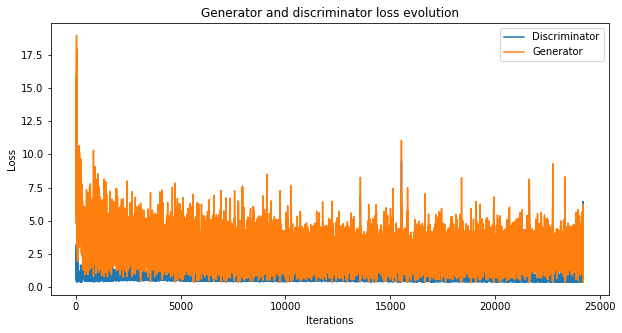

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and discriminator loss evolution")
plt.plot(loss_d_tracker, label="Discriminator")
plt.plot(loss_g_tracker, label="Generator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evolution of the tracking sample

##### To do

##### Done
- Instead of displaying with the HTML module, save as a gif and display the gif
    - http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/

In [15]:
# Save evolution as a gif
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims)

ani.save('../animations/animation_{}.gif'.format(model_date), writer='imagemagick', fps=3)
plt.close()

In [16]:
# Display the gif
Image(url='../animations/animation_{}.gif'.format(model_date))

### Visualization of the tracking sample at the end

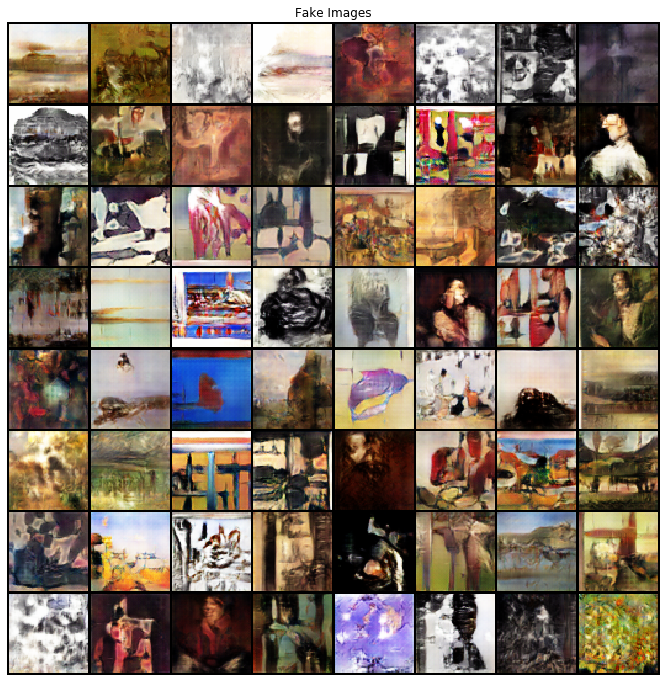

In [17]:
plt.figure(figsize = (12, 12))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

### Load the trained generator, generate samples and save them

##### To do
- Save generated samples

##### Done
- Should the model be moved to gpu (if available) after it is loaded? $\rightarrow$ Yes. Also make sure to call `input = input.to(device)` on any input tensors that you feed to the model
- Load on different devices
- Make it device agnostic
- Test function version

In [18]:
def load_model(model_path, trained_on):
    '''
    Loads a model saved at model_path on device marker
    parameters:
        model_path: string indicating where is the model (.pt or .pth)
        trained_on: string indicating if the model was trained on a cpu ('cpu') or gpu ('cuda:0')
    output:
        model: Trained generator model instance
    VERY IMPORTANT: Make sure to call input = input.to(device)
    on any input tensors that you feed to the model if loading on gpu!!!
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Generator()
    if str(device) == trained_on:
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [19]:
# Load model
loaded_gen = load_model('../models/trained_generator_I_7200.pth', 'cuda:0')

FileNotFoundError: [Errno 2] No such file or directory: '../models/trained_generator_I_7200.pth'

In [ ]:
# Generate fake batch with the loaded model
noise = torch.randn(128, code_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = loaded_gen(noise).cpu()

In [ ]:
# Plot the fake batch
plt.figure(figsize = (12,12))
plt.axis("off")
plt.title("Fake Images")
generated = vutils.make_grid(fake_images[:64], padding=2, normalize=True) # [:64] to display only the first 64 images
plt.imshow(np.transpose(generated, (1,2,0)))